In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    r"/home/azureuser/cloudfiles/code/Users/soutrik.chowdhury/abi_genai_bert_classifier"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/abi_genai_bert_classifier


In [3]:
!ls

README.md  baseline_bert.pt  data  notebook


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torcheval.metrics import BinaryAccuracy, BinaryF1Score, BinaryPrecision,BinaryRecall,BinaryConfusionMatrix
from tqdm import tqdm
import warnings, random
from glob import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from torchinfo import summary
from torchview import draw_graph
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#### Helpers

In [5]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=3, verbose=True, delta=1e-5, trace_func=print, path="baseline.pt"
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
# Set manual seed since nn.Parameter are randomly initialzied
seed = 42
set_seed(seed)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Random seed set as 42


#### Data Preparation and preprocessing

In [9]:
class_names = ['Simple', 'Complex']
evaluation_size = 0.25

In [10]:
folder_path = os.path.join(os.getcwd(), "data/labeled_data")
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
concatenated_df = pd.concat(
    (pd.read_csv(os.path.join(folder_path, file)) for file in csv_files),
    ignore_index=True,
)

In [11]:
print(concatenated_df.isnull().sum())

Domain        0
Question      0
FinalLabel    0
dtype: int64


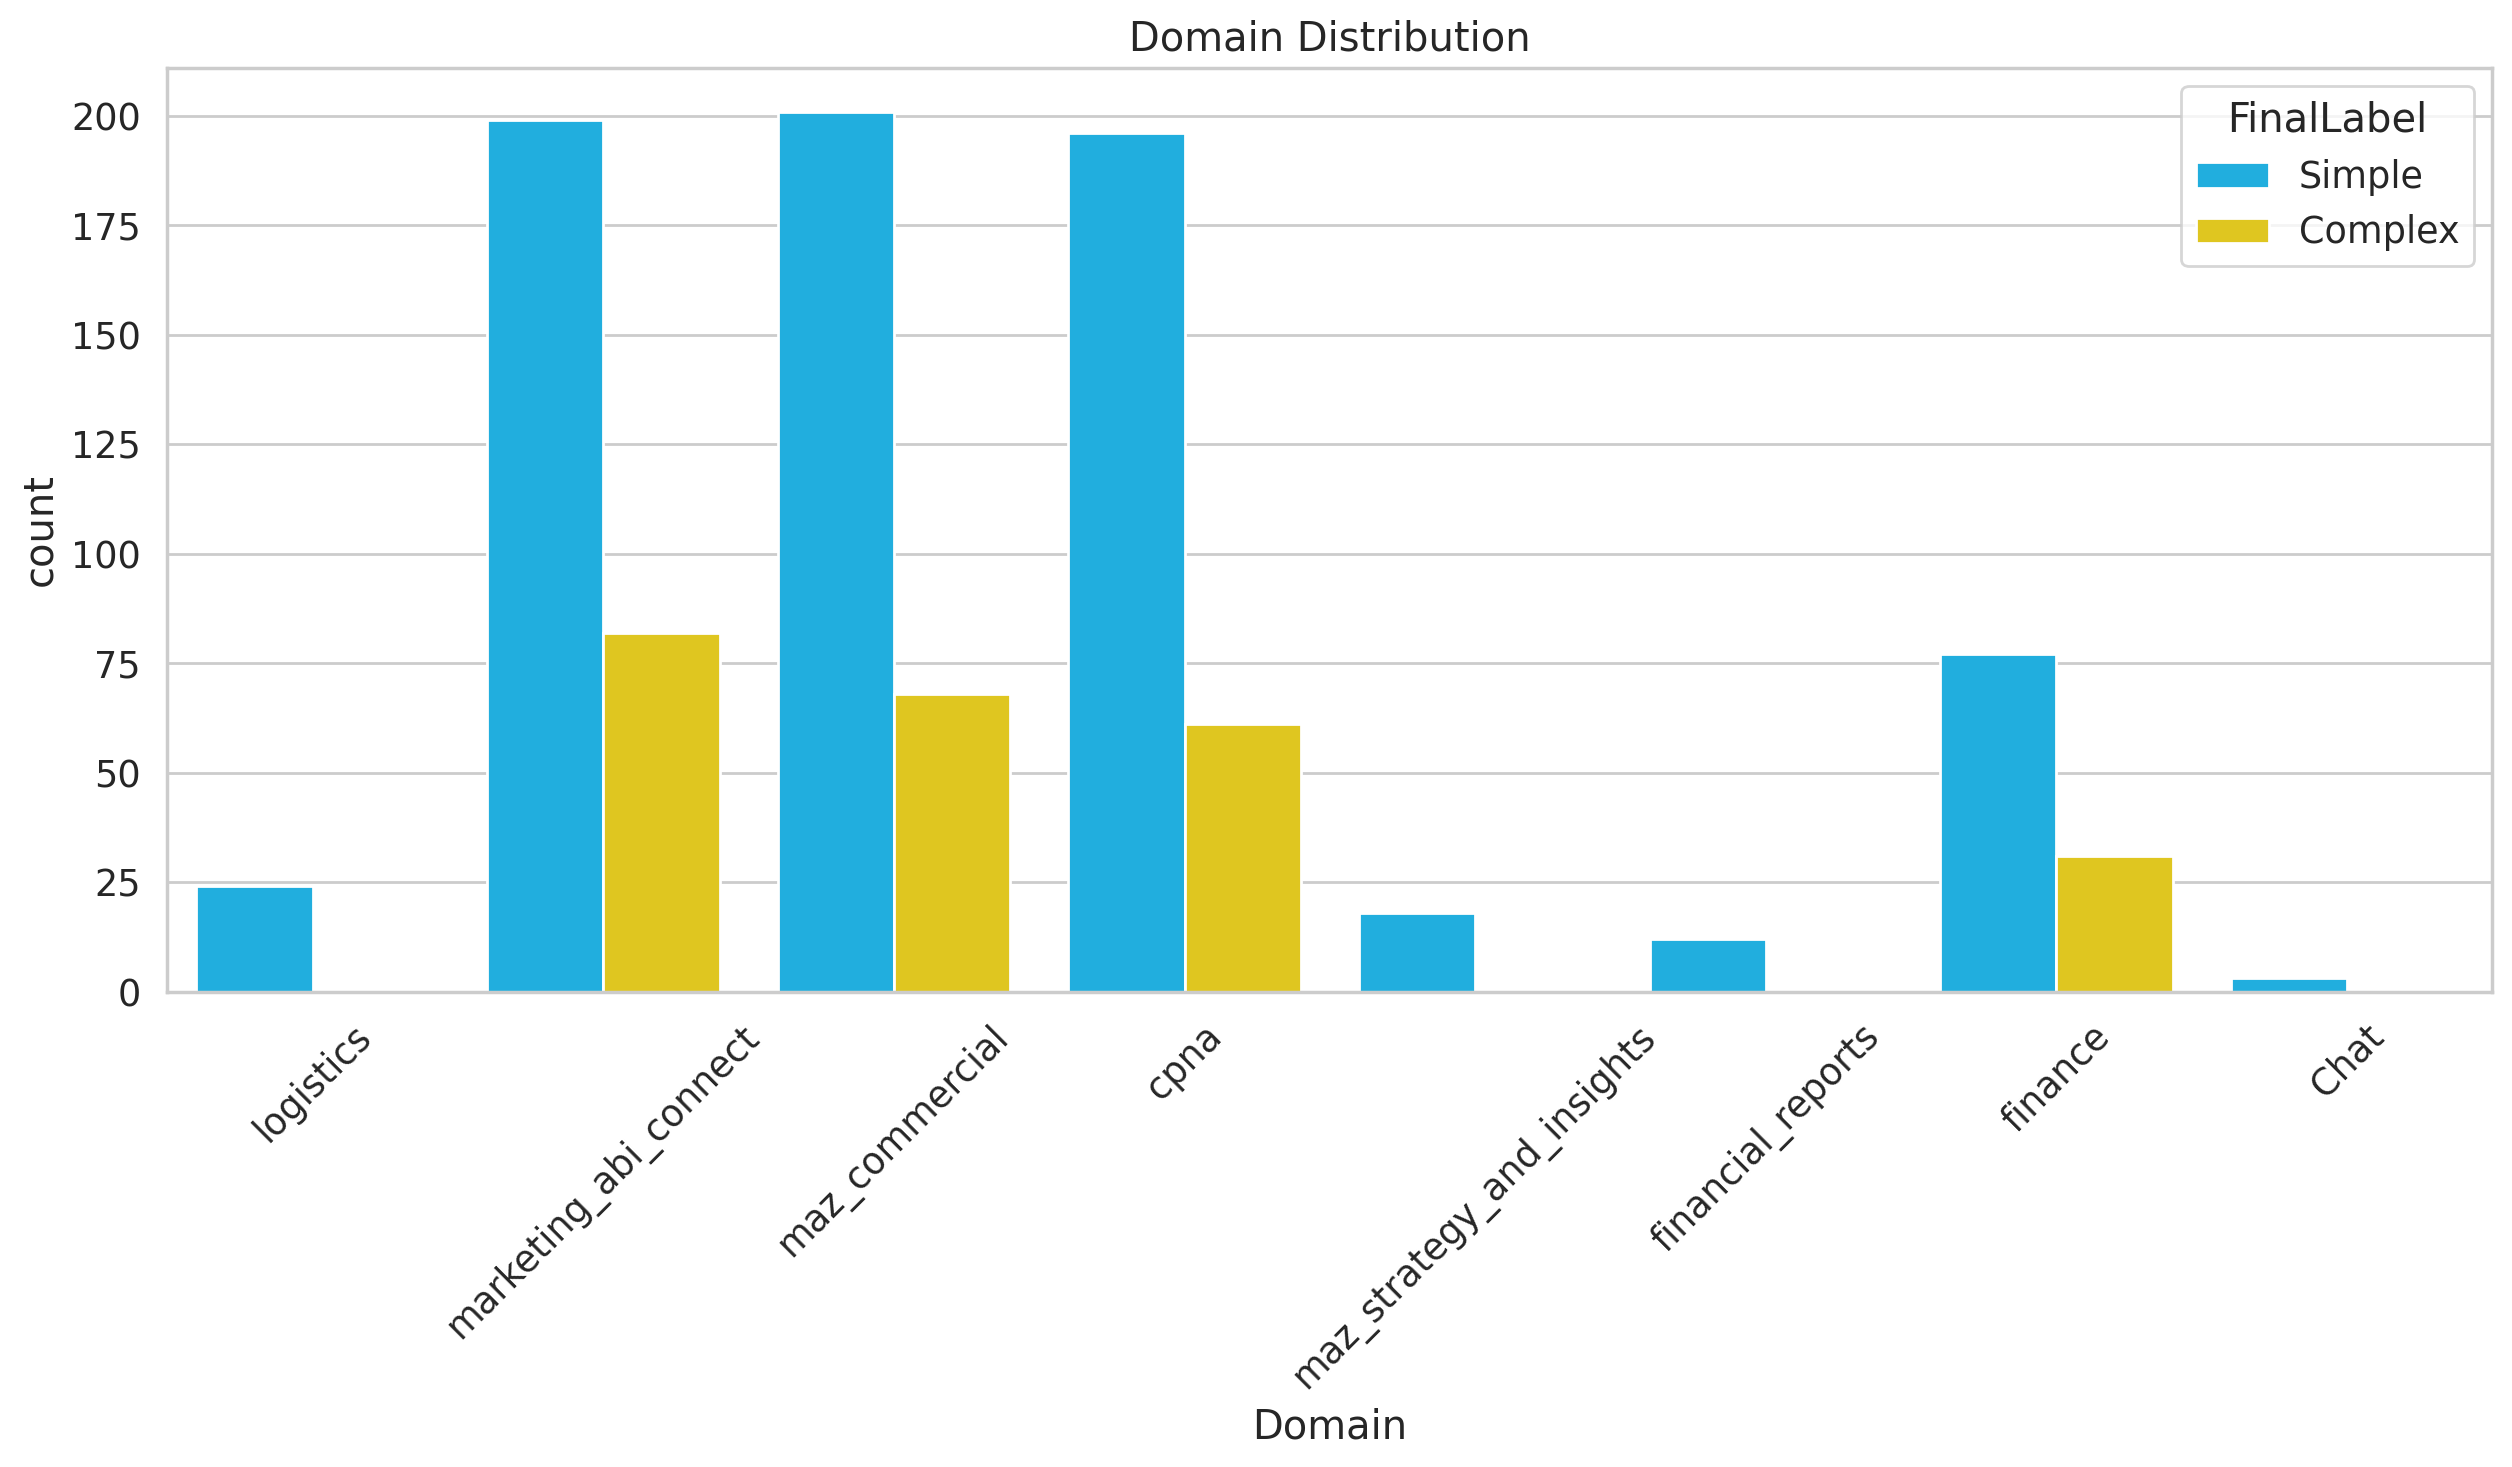

In [12]:
# check the distribution of the labels
plt.figure(figsize=(15, 6))
sns.countplot(data=concatenated_df, x='Domain', hue='FinalLabel')
plt.xticks(rotation=45)
plt.title('Domain Distribution')
plt.show()

In [13]:
# Normalization of labels
concatenated_df["FinalLabel"] = concatenated_df["FinalLabel"].apply(lambda x: x.upper()).map({"SIMPLE":0,"COMPLEX":1})
concatenated_df["FinalLabel"] = concatenated_df["FinalLabel"].astype(int)

In [14]:
# startified train test split
train_df, test_df = train_test_split(
    concatenated_df,
    test_size=evaluation_size,
    random_state=seed,
    stratify=concatenated_df["FinalLabel"],
)
print(train_df.shape)
print(test_df.shape)

(729, 3)
(243, 3)


In [15]:
print(train_df["FinalLabel"].value_counts()/len(train_df))
print(test_df["FinalLabel"].value_counts()/len(test_df))

0    0.750343
1    0.249657
Name: FinalLabel, dtype: float64
0    0.753086
1    0.246914
Name: FinalLabel, dtype: float64


In [ ]:
# Real scenarios
raw_sentences = ["What was the sales for brand Hurricane in India?",
                 "How did the sales for brand Hurricane changed over last one year?",
                 "Explain how has the impact on water shortage on the production of beer in India?",
                 "How is the performance of Classic lager segment in LP TY compared to LP YA?",
                 "Detail the reasons for drop in sales for brand Corona in the west?",
                 "How did the sales evolved for brand Jupiter over the period of last 6 months?",
                 "Explain in details the reasons for the abrupt changes in sales pattern of Becks in Asian markets?"]

targets = [0, 0, 1, 1, 1, 0, 1]

#### Pretrained BERT tokenization

In [16]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
MAX_LEN = 128
BATCH_SIZE = 16

In [17]:
class QuestionClassficationDataset(Dataset):

    def __init__(self, question, targets, max_len):
        self.question = question
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained(
            PRE_TRAINED_MODEL_NAME, force_download=True
        )
        self.max_len = max_len

    def __len__(self):
        return len(self.question)

    def __getitem__(self, item):
        review = str(self.question[item])
        if self.targets is not None:
            target = self.targets[item]

        # token encoder
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )

        if self.targets is not None:
            return {
                "review_text": review,
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "targets": torch.tensor(target, dtype=torch.float),
            }

        else:

            return {
                "review_text": review,
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"],
            }

In [18]:
def create_data_loader(
    question=None,
    targets=None,
    max_len=None,
    batch_size=None,
    shuffle=None,
    num_workers=4,
    pin_memory=True,
):
    dataset = QuestionClassficationDataset(
        question=question,
        targets=targets,
        max_len=max_len,
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

In [19]:
# train test dataloader
train_loader = create_data_loader(
    question=train_df["Question"].values,
    targets=train_df["FinalLabel"].values,
    max_len=MAX_LEN,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = create_data_loader(
    question=test_df["Question"].values,
    targets=test_df["FinalLabel"].values,
    max_len=MAX_LEN,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [20]:
# batched of 8 with 128 token size
for sample_data in train_loader:
  print(sample_data.keys())
  print(sample_data["input_ids"].shape)
  print(sample_data["attention_mask"].shape)
  print(sample_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])




In [21]:
for test_data in test_loader:
  print(test_data.keys())
  print(test_data["input_ids"].shape)
  print(test_data["attention_mask"].shape)
  print(test_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])




In [22]:
sample_data["targets"]

tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

#### Basic Model Training

In [23]:
LR = 2e-05
EPOCHS = 20

In [56]:
class BertSentimentClassifier(nn.Module):

    def __init__(self, n_classes, dropout=0.25):
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(
            PRE_TRAINED_MODEL_NAME, force_download=False
        )
        self.drop = nn.Dropout(p=dropout)
        self.ln = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):

        model_op = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = model_op["pooler_output"]
        norm_output = self.ln(pooled_output)
        output = self.drop(norm_output)
        return self.classifier(output)

In [57]:
bert_base_classifier = BertSentimentClassifier(1).to(device)

In [26]:
# input1 = torch.randn((1, 16, 128), device=device)
# input2 = torch.randn((1, 16,128),device=device)
# summary(bert_base_classifier, input_data = [input1, input2])

In [27]:
def train_module(
    model: torch.nn.Module,
    device: torch.device,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    metric,
    scheduler,
    train_losses: list,
    train_metrics: list,
):
    """ Trains the model for one epoch using the training dataloader."""
    # setting model to train mode
    model.train()
    pbar = tqdm(train_dataloader)

    # batch metrics
    train_loss = 0
    train_metric = 0
    processed_batch = 0

    for _, data in enumerate(pbar):

        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)

        # print(f"The target shape is {targets.shape}")

        # model output
        outputs = model(ids, mask)
        outputs = outputs.flatten()
        # print(f"The output shape is {outputs.shape}")

        # calc loss
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        # print(f"training loss for batch {idx} is {loss}")

        # backpropagation
        optimizer.zero_grad()  # flush out  existing grads
        loss.backward()  # back prop of weights wrt loss
        # gradient clipping -- prevent gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # improvement steps
        optimizer.step()  # optimizer step -> minima
        if scheduler is not None:
            scheduler.step()  # scheduler step -> lr scheduling

        # metric calc
        metric.update(outputs, targets)
        train_metric += metric.compute().detach().item()

        # updating batch count
        processed_batch += 1

        pbar.set_description(
            f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}"
        )

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    train_losses.append(train_loss / processed_batch)
    train_metrics.append(train_metric / processed_batch)

    return train_losses, train_metrics

In [28]:
def test_module(
    model: torch.nn.Module,
    device: torch.device,
    test_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    metric,
    test_losses,
    test_metrics,
):
    """ Tests the model for one epoch using the test dataloader."""
    # setting model to eval mode
    model.eval()
    pbar = tqdm(test_dataloader)

    # batch metrics
    test_loss = 0
    test_metric = 0
    processed_batch = 0

    with torch.inference_mode():
        for _, data in enumerate(pbar, 0):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            # print(f"The target shape is {targets.shape}")

            # model output
            outputs = model(ids, mask)
            outputs = outputs.flatten()

            # print(f"The output shape is {outputs.shape}")

            # calc loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # metric calc
            metric.update(outputs, targets)
            test_metric += metric.compute().detach().item()

            # updating batch count
            processed_batch += 1

            pbar.set_description(
                f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}"
            )

        # It's typically called after the epoch completes
        metric.reset()
        # updating epoch metrics
        test_losses.append(test_loss / processed_batch)
        test_metrics.append(test_metric / processed_batch)

    return test_losses, test_metrics

In [58]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_base_classifier.parameters(), lr=LR, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device=device)

# early stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path="baseline_bert.pt")

In [59]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_base_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_base_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )
  scheduler.step()

  print(f"The learing rate is going to be next::{scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], bert_base_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/20
----------


Avg Train Loss: 0.7323141694068909 Avg Train Metric: 0.0:   2%|███████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 1/46 [00:00<00:13,  3.38it/s]

Avg Train Loss: 0.35379159450531006 Avg Train Metric: 0.39731629038958444: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.88it/s]


The learing rate is going to be next::[1.8978260869565218e-05]
Validation loss decreased (inf --> 0.188621).  Saving model ...
Epoch 2/20
----------


Avg Train Loss: 0.2054551079079671 Avg Train Metric: 0.8934009165867515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.86it/s]


The learing rate is going to be next::[1.7956521739130437e-05]
Validation loss decreased (0.188621 --> 0.135382).  Saving model ...
Epoch 3/20
----------


Avg Train Loss: 0.155036699376069 Avg Train Metric: 0.9201966277931047: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.86it/s]


The learing rate is going to be next::[1.6934782608695653e-05]
EarlyStopping counter: 1 out of 5
Epoch 4/20
----------


Avg Train Loss: 0.09631508849966137 Avg Train Metric: 0.9446670581465182: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.83it/s]


The learing rate is going to be next::[1.591304347826087e-05]
EarlyStopping counter: 2 out of 5
Epoch 5/20
----------


Avg Train Loss: 0.11812409374397248 Avg Train Metric: 0.9482333012249159: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.86it/s]


The learing rate is going to be next::[1.4891304347826087e-05]
Validation loss decreased (0.135382 --> 0.095343).  Saving model ...
Epoch 6/20
----------


Avg Train Loss: 0.06175919408079884 Avg Train Metric: 0.9724113643169403: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.87it/s]


The learing rate is going to be next::[1.3869565217391305e-05]
EarlyStopping counter: 1 out of 5
Epoch 7/20
----------


Avg Train Loss: 0.04653434589019288 Avg Train Metric: 0.9676067492236262: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.84it/s]


The learing rate is going to be next::[1.2847826086956523e-05]
EarlyStopping counter: 2 out of 5
Epoch 8/20
----------


Avg Train Loss: 0.027806837063626914 Avg Train Metric: 0.9827996971814529: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.88it/s]


The learing rate is going to be next::[1.182608695652174e-05]
EarlyStopping counter: 3 out of 5
Epoch 9/20
----------


Avg Train Loss: 0.026855664941451876 Avg Train Metric: 0.9946239240791487: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.87it/s]


The learing rate is going to be next::[1.0804347826086959e-05]
EarlyStopping counter: 4 out of 5
Epoch 10/20
----------


Avg Train Loss: 0.013727456286331922 Avg Train Metric: 0.9938868672951408: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.69it/s]


The learing rate is going to be next::[9.782608695652175e-06]
EarlyStopping counter: 5 out of 5
Early stopping
CPU times: user 55.4 s, sys: 13.1 s, total: 1min 8s
Wall time: 1min 17s


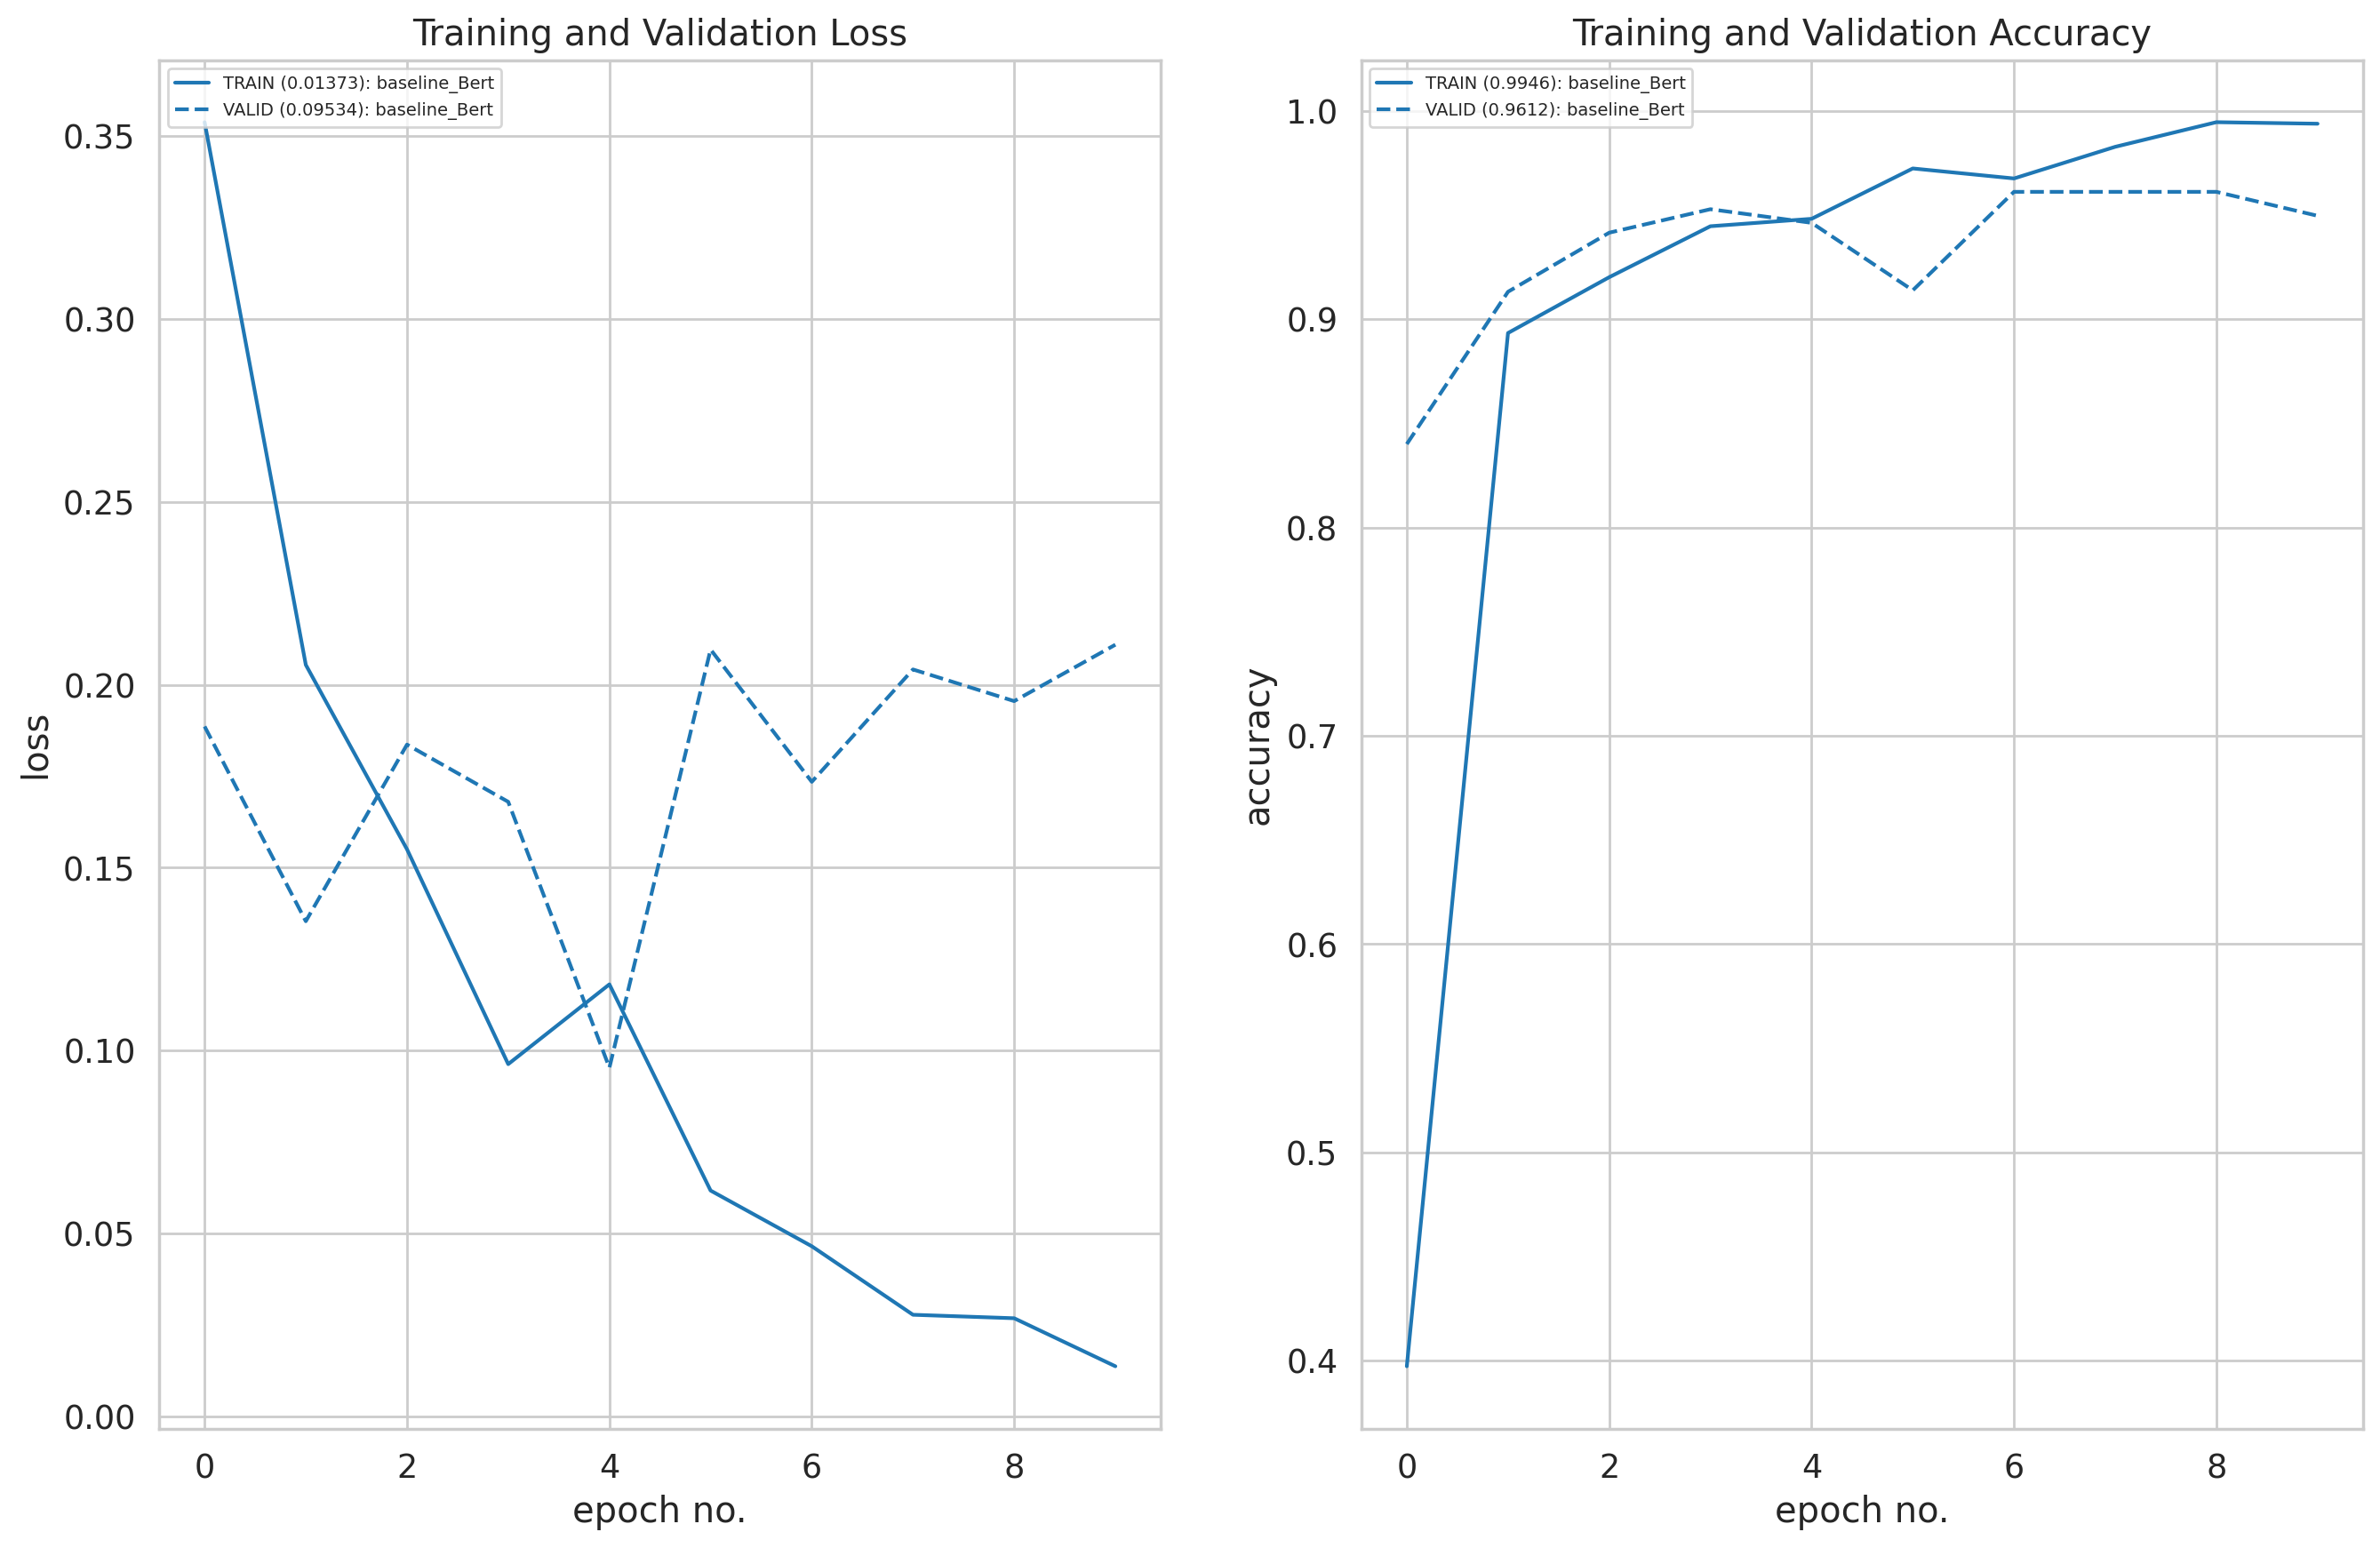

In [60]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline_Bert'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [84]:
def get_predictions(model, data_loader, prob_thresh=0.7):
    """Returns the predictions and the real values"""
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask
            ).flatten()

            probs = torch.sigmoid(outputs)

            preds = torch.where(
                probs > prob_thresh,
                torch.tensor(1.0).to(device),
                torch.tensor(0.0).to(device),
            )

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu().numpy()
    prediction_probs = np.round(torch.stack(prediction_probs).cpu().numpy(), 3)
    real_values = torch.stack(real_values).cpu().numpy()

    return review_texts, predictions, prediction_probs, real_values

In [62]:
live_loader = create_data_loader(
    question=raw_sentences,
    targets=targets,
    max_len=MAX_LEN,
    batch_size=1,
    shuffle=False,
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [63]:
review_texts, predictions, prediction_probs, real_values = get_predictions(bert_base_classifier , live_loader)

In [64]:
predictions

array([0., 0., 1., 1., 1., 0., 1.], dtype=float32)

#### More Stable model

In [75]:
class BertSentimentClassifierAdvanced(nn.Module):

  def __init__(self, n_classes, fc_hidden = 128 , dropout = 0.25):
    super(BertSentimentClassifierAdvanced, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.bn = nn.BatchNorm1d(self.bert.config.hidden_size)
    self.pooler = nn.Linear(self.bert.config.hidden_size, fc_hidden)
    self.classifier = nn.Linear(fc_hidden, n_classes)


  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.bn(pooled_output)
    output = self.drop(pooled_output)
    output = self.pooler(output)
    return self.classifier(output)

In [76]:
bert_advanced_classifier = BertSentimentClassifierAdvanced(1).to(device)

In [77]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_advanced_classifier.parameters(), lr=LR, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device=device)

# early stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path="advanced_bert.pt")

In [78]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_advanced_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_advanced_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )
  scheduler.step()

  print(f"The learing rate is going to be next::{scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], bert_advanced_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/20
----------


Avg Train Loss: 0.6921289563179016 Avg Train Metric: 0.0:   2%|███████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 1/46 [00:00<00:14,  3.02it/s]

Avg Train Loss: 0.37407362926751375 Avg Train Metric: 0.3435751105780187: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.78it/s]


The learing rate is going to be next::[1.8978260869565218e-05]
Validation loss decreased (inf --> 0.146022).  Saving model ...
Epoch 2/20
----------


Avg Train Loss: 0.1551106658703445 Avg Train Metric: 0.890800460525181: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.70it/s]


The learing rate is going to be next::[1.7956521739130437e-05]
Validation loss decreased (0.146022 --> 0.098901).  Saving model ...
Epoch 3/20
----------


Avg Train Loss: 0.11693138357899759 Avg Train Metric: 0.9626721908216891: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.78it/s]


The learing rate is going to be next::[1.6934782608695653e-05]
EarlyStopping counter: 1 out of 5
Epoch 4/20
----------


Avg Train Loss: 0.10366130662758065 Avg Train Metric: 0.9426494331463523: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.80it/s]


The learing rate is going to be next::[1.591304347826087e-05]
EarlyStopping counter: 2 out of 5
Epoch 5/20
----------


Avg Train Loss: 0.058505928991666144 Avg Train Metric: 0.9739766328231149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.81it/s]


The learing rate is going to be next::[1.4891304347826087e-05]
EarlyStopping counter: 3 out of 5
Epoch 6/20
----------


Avg Train Loss: 0.03143230982570221 Avg Train Metric: 0.9731104011121003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.82it/s]


The learing rate is going to be next::[1.3869565217391305e-05]
EarlyStopping counter: 4 out of 5
Epoch 7/20
----------


Avg Train Loss: 0.023519949667388573 Avg Train Metric: 0.9722982670949853: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.77it/s]


The learing rate is going to be next::[1.2847826086956523e-05]
EarlyStopping counter: 5 out of 5
Early stopping
CPU times: user 38.7 s, sys: 9.37 s, total: 48.1 s
Wall time: 54.2 s


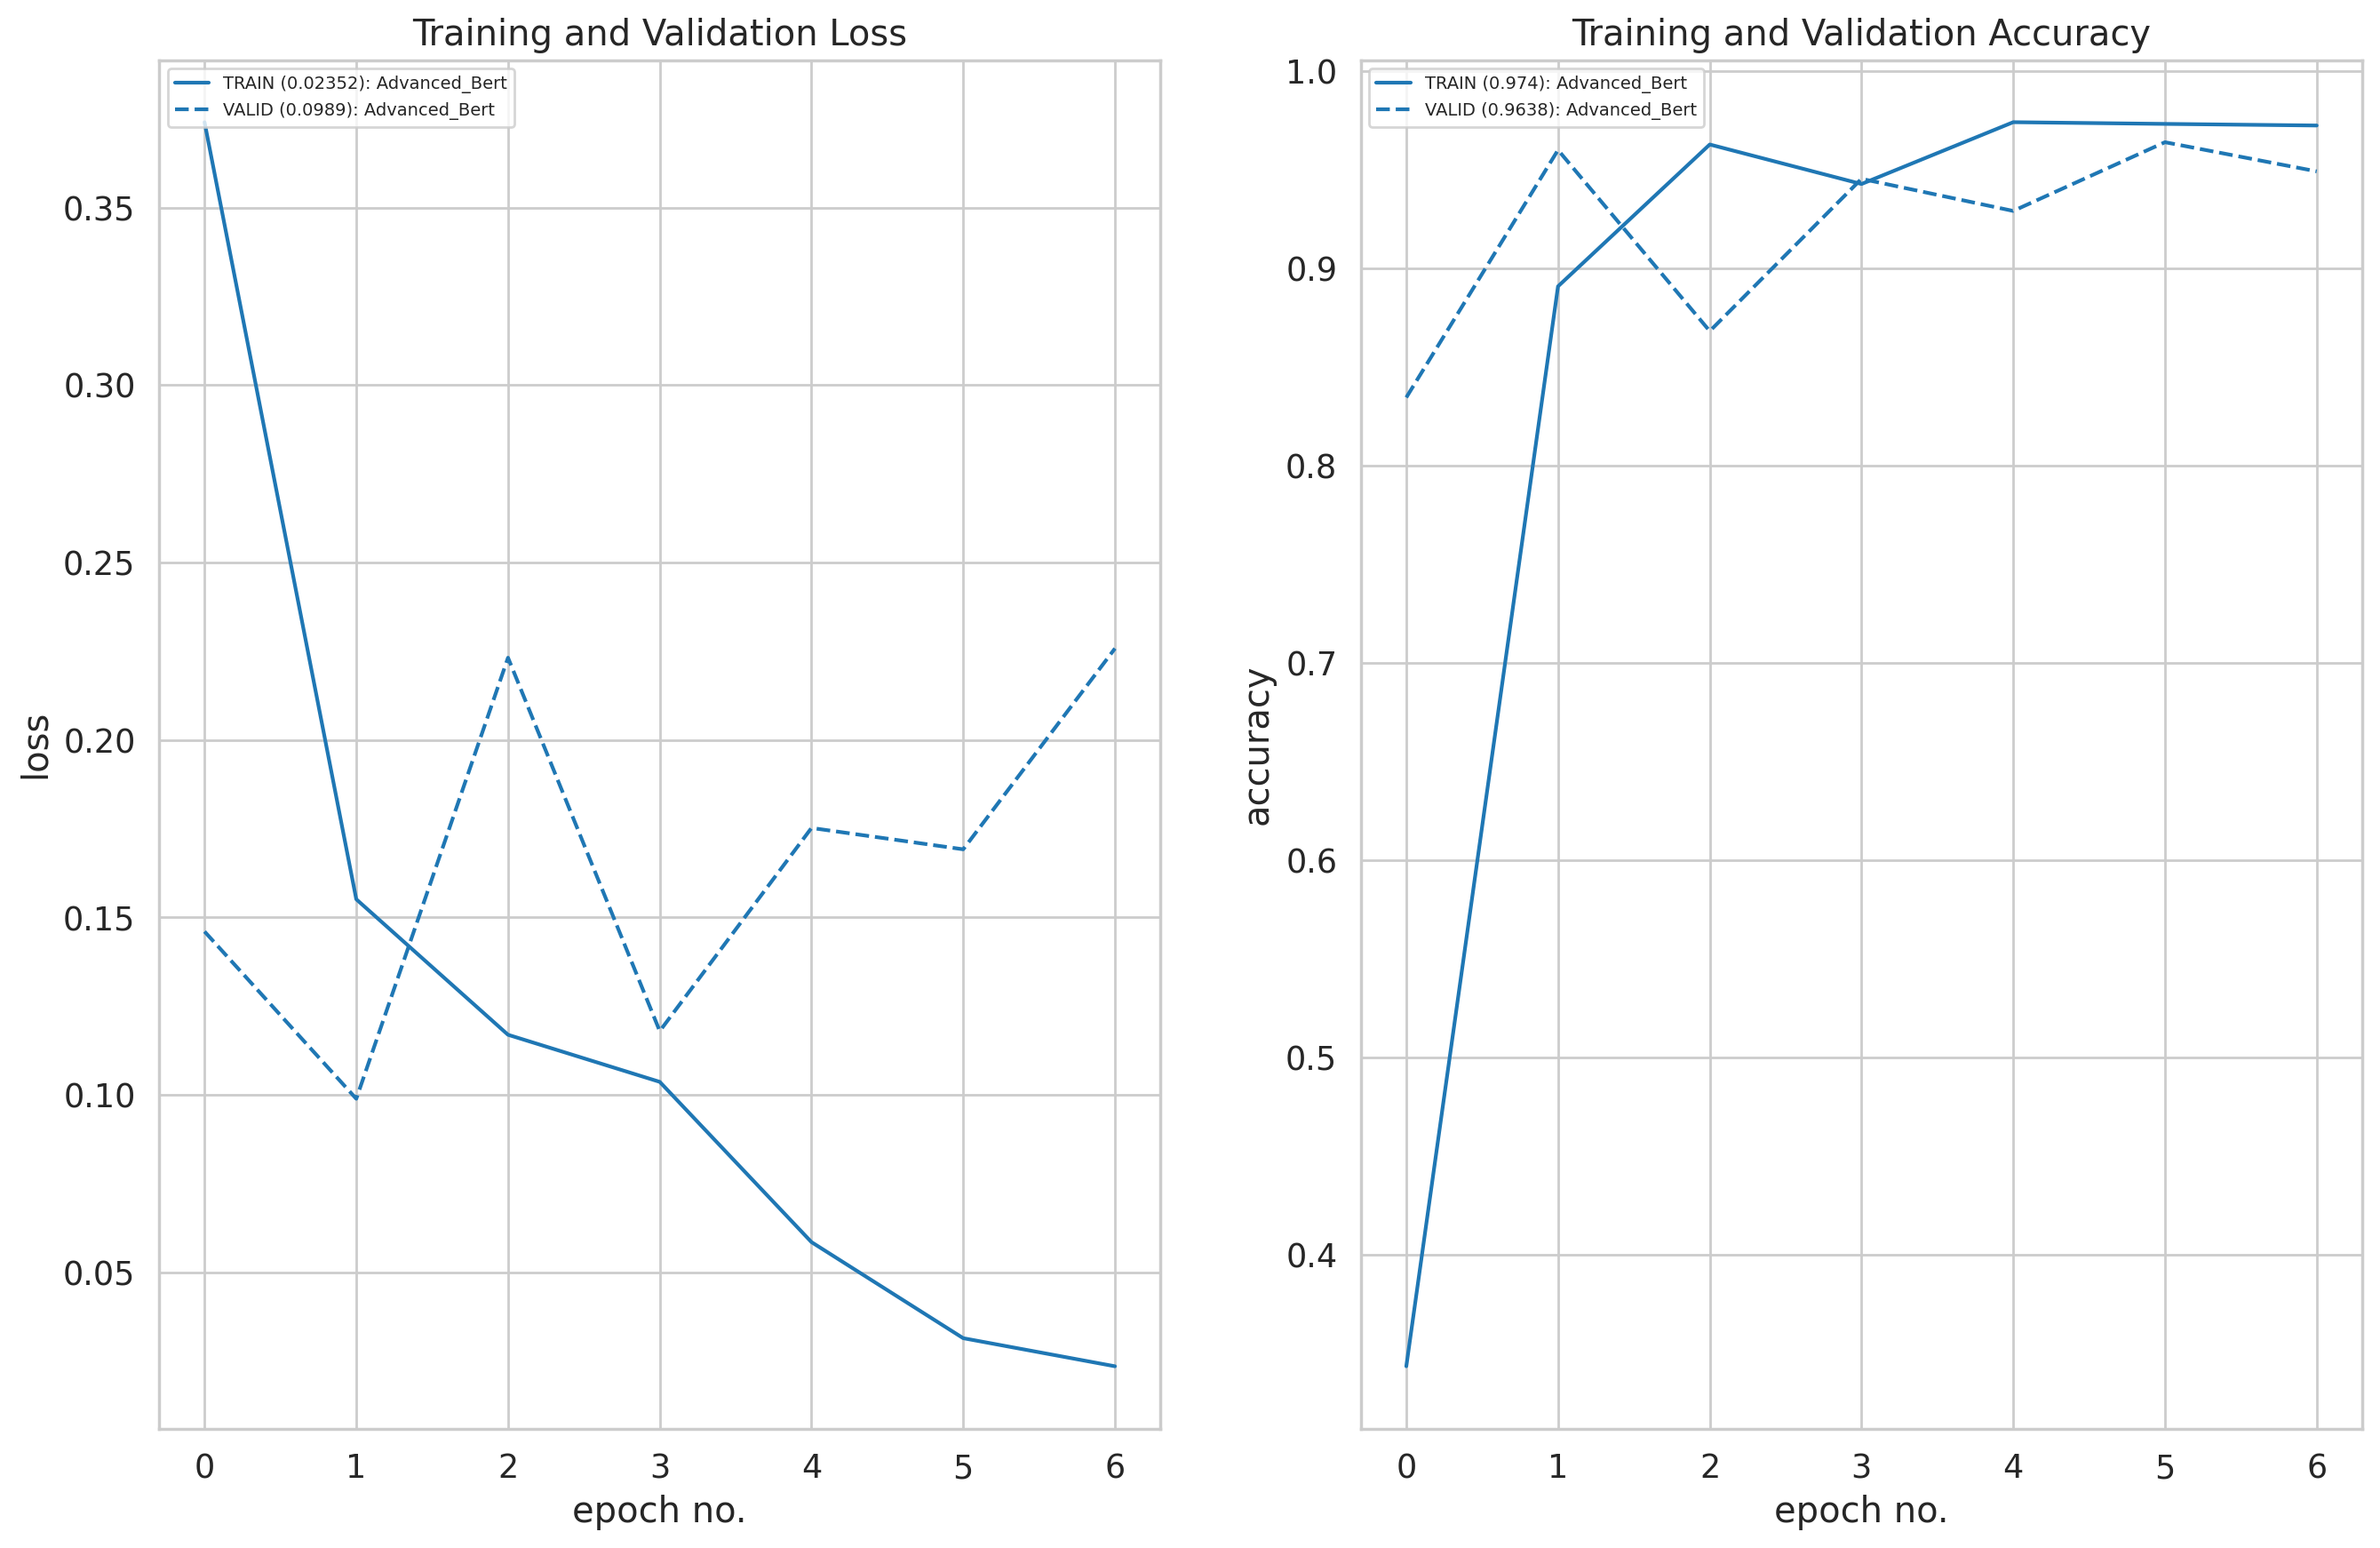

In [79]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Advanced_Bert'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [82]:
review_texts, predictions, prediction_probs, real_values = get_predictions(bert_advanced_classifier , live_loader)

In [83]:
predictions

array([0., 0., 1., 1., 1., 0., 1.], dtype=float32)